#Tercer intento#



*   Solo con los datos de Madrid de Idealista2018
*   Madrid_Sale.csv y Madrid_Polygons.rda bajados de https://github.com/paezha/idealista18/tree/e2cfe3f621e1c37f226ce956f61b7306c42d5721/data


*   archivo Madrid_Polygons.rda transformado en csv con Notebook en R Script R rda a csv.ipyn https://colab.research.google.com/drive/1I06zwKUreseL1p87dHq0TzMheUHiEmVc


*   Exploración de datos (EDA) copiado de https://github.com/enricobonii/Idealista-Project/blob/main/IdealistaProject%20v4.ipynb
*Agregar la Columna neighbourhood a df_Madrid: de la latitud y longitud de cada casa se busca el barrio al que corresponde en Madrid_Polygons.csv

* la variable que vamos intentar predecir va a ser la diferencia en % entre el precio del piso y el precio medio por barrio - usaremos solo los datos del cuarto trimestre, quitando los que la diferencia sea mayor del 100%

* se usan varios modelos, y luego se calcula el error en el precio





In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Ruta al archivo CSV en Google Drive
file_path = '/content/drive/My Drive/Idealista_2024/datos_2018/'

In [ ]:
from getpass import getpass
import os

# Solicita el token personal de GitHub
token = getpass('GitHub Token: ')

# Define la URL del repositorio y la ruta de clonación
repo_url = "https://github.com/edouardor/Idealista_2024.git"
destino = "/content/drive/MyDrive/Idealista_2024"

# Clona el repositorio en la carpeta de Google Drive
os.system(f'git clone https://{token}@github.com/edouardor/Idealista_2024.git {destino}')


In [ ]:
%cd /content/drive/MyDrive/Idealista_2024

In [ ]:
!ls -a


In [ ]:
!git config --global user.email "edouardo@hotmail.es"
!git config --global user.name "edouardor"

In [ ]:
# Mostrar la rama actual
!git branch


In [ ]:
# Crear y cambiar a una nueva rama
!git checkout -b rama-limpia

# Agregar los archivos modificados
!git add .

# Hacer un commit
!git commit -m "Cambios realizados desde Google Colab en nueva rama - notebook limpiado"

# Subir la nueva rama al remoto
!git push -u origin rama-limpia


In [ ]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import radians, cos, sin, asin, sqrt
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_columns', None)

## Initializing Datasets

###Solo Madrid


In [ ]:

df= pd.read_csv(file_path+'gdf_Madrid_with_metro_count.csv')


In [ ]:
gdf = pd.read_csv(file_path+'Madrid_Polygons_with_mean_unitprice.csv')

*para poner luego los clusters definidos para cada barrio*

In [ ]:
df.head(3)

## Exploratory Data Analysis

In [ ]:
print(df.dtypes)

From here we can observe that the formatted variable types make sense with the expected and are homogeneous among the different datasets.

In [ ]:
df.describe(include='all')

In [ ]:
# prompt: drop observertions where df[df['ROOMNUMBER']>20]

df = df[df['ROOMNUMBER'] <= 20]

In [ ]:
# dime cuales son los valores medios de UNITPRICE para cada periodo, y la diferencia en % con el primer periodo - con dos decimales es suficiente - pon tambien cuantos datos hay en df para cada periodo


# Group data by 'PERIOD' and calculate the mean of 'UNITPRICE'
mean_unitprice_by_period = df.groupby('PERIOD')['UNITPRICE'].agg(['mean', 'count'])

# Calculate the percentage difference from the first period
first_period_mean = mean_unitprice_by_period['mean'].iloc[0]
mean_unitprice_by_period['pct_change'] = ((mean_unitprice_by_period['mean'] - first_period_mean) / first_period_mean) * 100

# Format the output
mean_unitprice_by_period['pct_change'] = mean_unitprice_by_period['pct_change'].round(2)
mean_unitprice_by_period = mean_unitprice_by_period.rename(columns={'mean':'mean_unitprice', 'count':'n_datapoints'})

mean_unitprice_by_period

In [34]:
# vamos a usar solo los del 4º periodo, para evitar las diferencias de precio debido a la inflacíon
df = df[df['PERIOD'] == 4]

In [35]:
# Agrupar por barrio y calcular el precio medio del m²
precio_medio_barrio = df.groupby('neighbourhood')['UNITPRICE'].mean().reset_index()

# Renombrar la columna para mayor claridad
precio_medio_barrio.rename(columns={'UNITPRICE': 'Precio_medio_m2'}, inplace=True)

print(precio_medio_barrio.head())

           neighbourhood  Precio_medio_m2
0  12 de Octubre-Orcasur      1855.416009
1               Abrantes      1956.641615
2                Acacias      4194.533621
3                Adelfas      4217.703417
4             Aeropuerto      1838.869115


In [36]:
# prompt: quiero poner en el dataframe una columna con el precio medio del m2 de cada barrio

# Fusionar el DataFrame original con el DataFrame de precios medios por barrio
df = pd.merge(df, precio_medio_barrio, on='neighbourhood', how='left')


###El valor a predecir va a ser la diferencia en % entre el precio por m2 del piso y el precio por m2 del barrio en el que se encuentra

In [37]:
# prompt: pon una columna con (UNITPRICE - Precio_medio_m2)/Precio_medio_m2

# Calculate the new column
df['diferencia_precio_m2'] = (df['UNITPRICE'] - df['Precio_medio_m2']) / df['Precio_medio_m2']

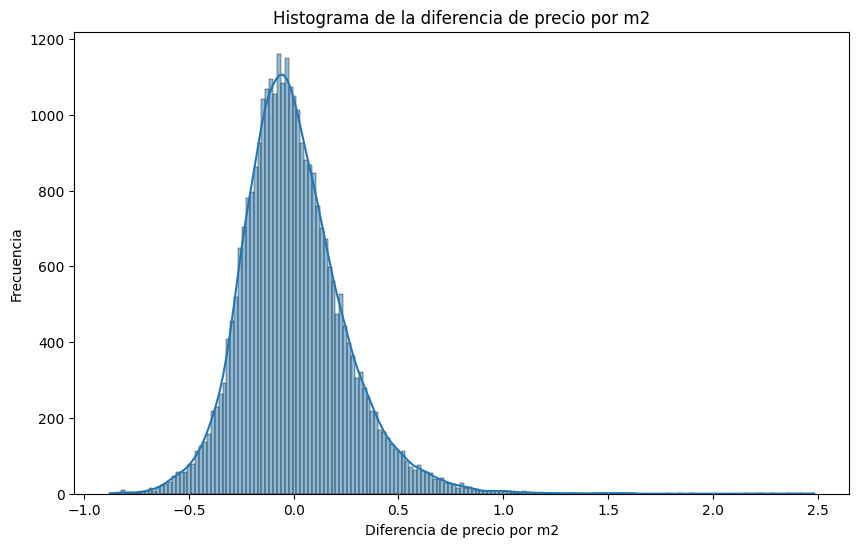

In [38]:
# prompt: haz un histograma con la columna diferencia_precio_m2 añadiendo una curva normal

# Plot the histogram with a normal curve
plt.figure(figsize=(10, 6))
sns.histplot(df['diferencia_precio_m2'], kde=True)  # kde=True adds the normal curve
plt.title('Histograma de la diferencia de precio por m2')
plt.xlabel('Diferencia de precio por m2')
plt.ylabel('Frecuencia')
plt.show()

In [39]:
# prompt: dime cuantos valores hay superiores a 1

# Assuming 'df' is your DataFrame and it has a column named 'diferencia_precio_m2'
count_greater_than_1 = len(df[df['diferencia_precio_m2'] > 1])
print(f"Hay {count_greater_than_1} valores superiores a 1 en la columna 'diferencia_precio_m2'.")

Hay 82 valores superiores a 1 en la columna 'diferencia_precio_m2'.


In [40]:
# prompt: quita los valores superiores a 1 en el df

# Assuming 'df' is your DataFrame and it has a column named 'diferencia_precio_m2'
df = df[df['diferencia_precio_m2'] <= 1]

In [41]:
# Calcular los percentiles para el 1% inferior y superior
lower_bound = df['PRICE'].quantile(0.01)  # 1% inferior
upper_bound = df['PRICE'].quantile(0.99)  # 1% superior

formatted_lower_bound = "{:,.0f}".format(lower_bound)
formatted_upper_bound = "{:,.0f}".format(upper_bound)

print(f"Vamos a quitar los pisos con un precio inferior a {formatted_lower_bound} euros")
print(f"y los que tengan un precio superior a {formatted_upper_bound} euros")

# Filtrar el DataFrame para conservar solo el 99% de los datos
df_filtered = df[(df['PRICE'] >= lower_bound) & (df['PRICE'] <= upper_bound)]

# Calculate the number of rows removed
removed_rows = len(df) - len(df_filtered)

print(f"Hemos quitado {removed_rows} pisos")
df = df_filtered

Vamos a quitar los pisos con un precio inferior a 75,000 euros
y los que tengan un precio superior a 2,227,670 euros
Hemos quitado 614 pisos


In [42]:
print(f"Quedan {len(df)} pisos")

Quedan 30698 pisos


## Multivariate Analysis

<Figure size 1600x1100 with 0 Axes>

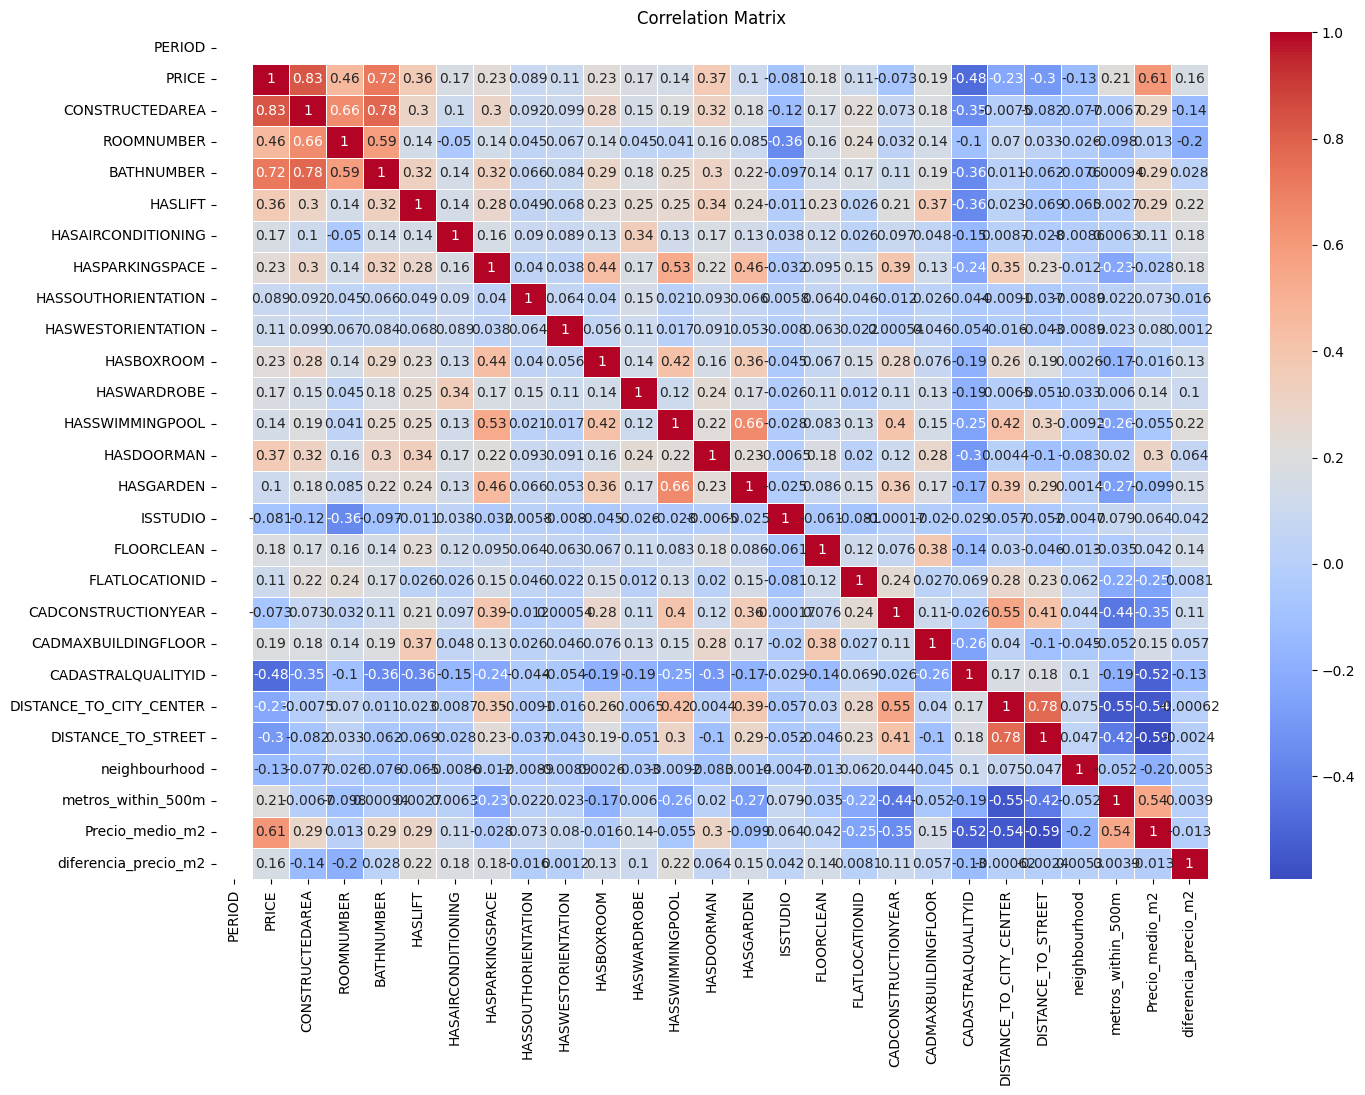

In [43]:
madrid = df.drop(columns=['ADOPERATIONID', 'UNITPRICE', 'LATITUDE', 'LONGITUDE','AMENITYID','ASSETID','ADTYPOLOGY','CITYNAME','ADOPERATION','ADTYPOLOGYID'])

# Encode the location names (label encoding)
madrid['neighbourhood'] = df['neighbourhood'].astype('category').cat.codes

plt.figure(figsize=(16, 11))
correlation_madrid = madrid.corr()

# Identify columns where absolute correlation with 'PRICE' is less than 0.07
low_corr_columns = correlation_madrid['PRICE'][abs(correlation_madrid['PRICE']) < 0.07].index

# Drop the identified columns from the DataFrame
madrid_filtered = madrid.drop(columns=low_corr_columns)

plt.figure(figsize=(16, 11))
correlation_madrid = madrid_filtered.corr()
sns.heatmap(correlation_madrid, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [44]:
print(madrid.dtypes)

PERIOD                       int64
PRICE                        int64
CONSTRUCTEDAREA              int64
ROOMNUMBER                   int64
BATHNUMBER                   int64
HASTERRACE                   int64
HASLIFT                      int64
HASAIRCONDITIONING           int64
HASPARKINGSPACE              int64
HASNORTHORIENTATION          int64
HASSOUTHORIENTATION          int64
HASEASTORIENTATION           int64
HASWESTORIENTATION           int64
HASBOXROOM                   int64
HASWARDROBE                  int64
HASSWIMMINGPOOL              int64
HASDOORMAN                   int64
HASGARDEN                    int64
ISDUPLEX                     int64
ISSTUDIO                     int64
ISINTOPFLOOR                 int64
FLOORCLEAN                 float64
FLATLOCATIONID             float64
CADCONSTRUCTIONYEAR          int64
CADMAXBUILDINGFLOOR          int64
CADDWELLINGCOUNT             int64
CADASTRALQUALITYID         float64
BUILTTYPEID_1                int64
BUILTTYPEID_2       

In [45]:
# print list of columns from correlation matrix in decreasing order of correlation with Price
correlation_madrid['PRICE'].sort_values(ascending=False)

,PRICE
PRICE,1.000000
CONSTRUCTEDAREA,0.827446
BATHNUMBER,0.724869
Precio_medio_m2,0.609239
ROOMNUMBER,0.462648
HASDOORMAN,0.365195
HASLIFT,0.359813
HASPARKINGSPACE,0.230619
HASBOXROOM,0.226485
metros_within_500m,0.209856


As per the above table, in Madrid,, we can see that the columns CONSTRUCTEDAREA, BATHNUMBER, ROOMNUMBER, HASDOORMAN, HASLIFT, HASPARKINGSPACE, metro_within_500 m, FloorClean are some of the columns that have a higher correlation with the PRICE of the asset listed.

**Analysing the pricing of assets based on location**

<ipython-input-46-91ba5e97af2c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='UNITPRICE', y='neighbourhood', data=average_prices, palette='viridis')


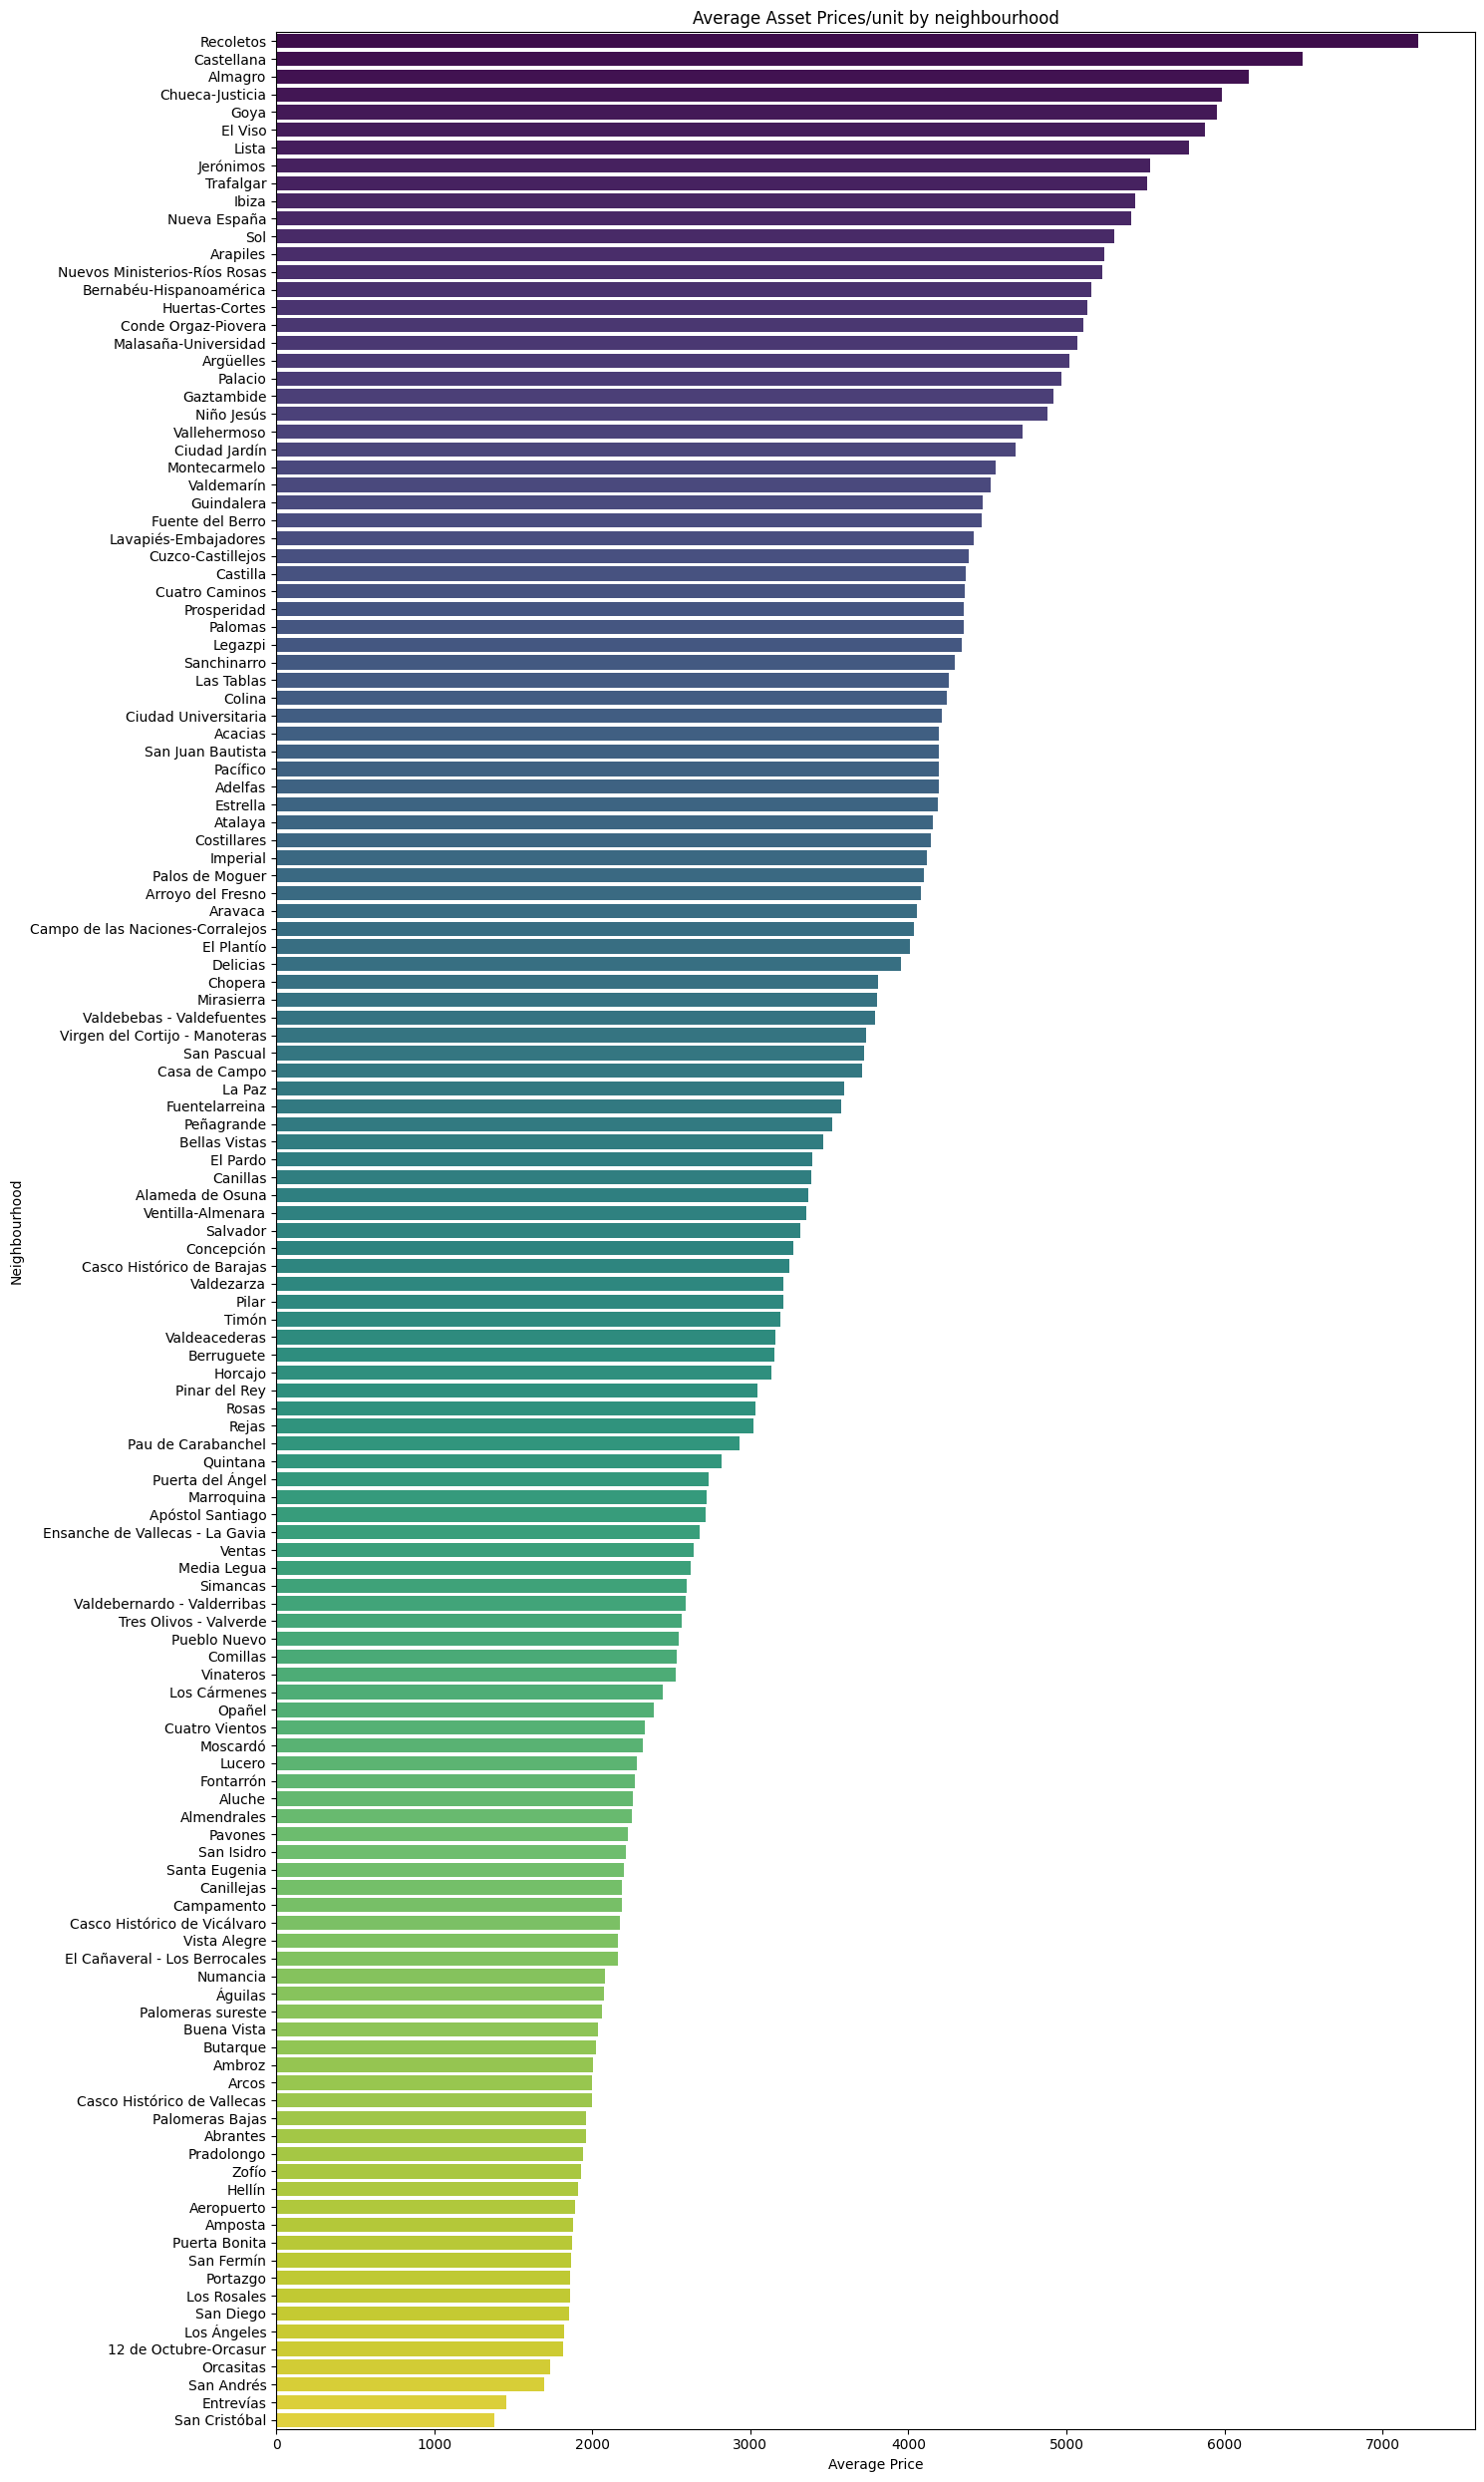

In [46]:
madrid_unit = df.copy()
# Encode the location names (label encoding)
madrid_unit['neighbourhood'] = df['neighbourhood'].astype('category').cat.codes

# Calculate average price by neighbourhood
average_prices = madrid_unit.groupby('neighbourhood')['UNITPRICE'].mean().reset_index()

#Map the neighbourhoods to their respective names
neighbourhood_map = dict(zip(madrid_unit['neighbourhood'], df['neighbourhood']))
average_prices['neighbourhood'] = average_prices['neighbourhood'].map(neighbourhood_map)

# Sort the neighbourhoods by average price in descending order
average_prices = average_prices.sort_values(by='UNITPRICE', ascending=False)

# Plot the average prices by neighbourhood
plt.figure(figsize=(15, 25))
sns.barplot(x='UNITPRICE', y='neighbourhood', data=average_prices, palette='viridis')

plt.title('Average Asset Prices/unit by neighbourhood')
plt.ylabel('Neighbourhood')
plt.xlabel('Average Price')
plt.tight_layout()

# Show the plot
plt.show()

As we see above, in Madrid, the neighbourhoods with the highest average asset unit prices (price per meter square) are: Recoletos, Castellana, Almagro, and Chueca. So the asset to be listed in/around these areas can have a high asking price (around 6500/m2). Places such as San Andres, Entrevias or San Cristobal have the lowest average asset prices. So the asset to be listed in/around these areas can have a low asking price (around 1300/m2).

In [47]:
madrid_unit['neighbourhood'].value_counts()

,count
neighbourhood,
67,1110
74,801
57,630
100,597
58,573
...,...
48,16
60,15
4,14


In [48]:
df_Madrid = df.copy()

Voy a volver a la idea anterior, y dejar los neighbourhood codificados:

In [ ]:
def target_encode(df, target_col, cat_col):
    target_mean = df.groupby(cat_col)[target_col].mean()
    return df[cat_col].map(target_mean)


df_Madrid['NEIGHBOURHOOD_ENCODED'] = target_encode(df_Madrid, 'PRICE', 'neighbourhood')


df_Madrid.dropna(inplace=True)

**Importamos las Librerías Necesarias**

In [49]:
from sklearn.cluster import KMeans
import seaborn as sns

**calculamos el precio medio del metro cuadrado por barrio:**

In [50]:
# Agrupar por barrio y calcular el precio medio del m²
precio_medio_barrio = df_Madrid.groupby('neighbourhood')['UNITPRICE'].mean().reset_index()

# Renombrar la columna para mayor claridad
precio_medio_barrio.rename(columns={'UNITPRICE': 'Precio_medio_m2'}, inplace=True)

print(precio_medio_barrio.head())


           neighbourhood  Precio_medio_m2
0  12 de Octubre-Orcasur      1812.786150
1               Abrantes      1959.107638
2                Acacias      4194.533621
3                Adelfas      4189.395975
4             Aeropuerto      1890.455004


**Determinamos el Número Óptimo de Grupos**

*Antes de realizar la agrupación, es útil determinar cuántos grupos (clusters) son apropiados. Una técnica común para esto es el método del codo.*

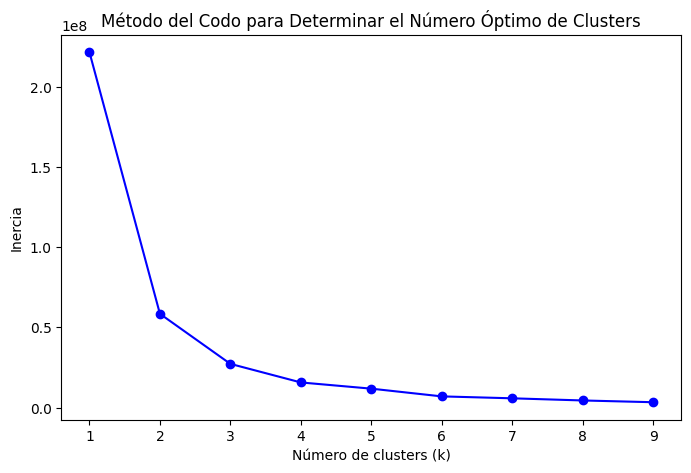

In [51]:
# Lista para almacenar la inercia
inercia = []
K = range(1, 10)

for k in K:
    modelo = KMeans(n_clusters=k, random_state=42)
    modelo.fit(precio_medio_barrio[['Precio_medio_m2']])
    inercia.append(modelo.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, inercia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.show()


*Buscamos un "codo" en la gráfica donde la inercia comienza a disminuir de manera menos pronunciada. Aquí k=6*

**Aplicar K-Means para Agrupar los Barrios**

In [52]:
# Definir el número de clusters
k_optimo = 6

# Inicializar y ajustar el modelo
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
precio_medio_barrio['Cluster'] = kmeans.fit_predict(precio_medio_barrio[['Precio_medio_m2']])

# Opcional: Añadir los centroides
centroides = kmeans.cluster_centers_


             neighbourhood  Precio_medio_m2  Cluster
109          San Cristóbal      1382.857239        3
51               Entrevías      1457.763194        3
108             San Andrés      1692.993345        3
85               Orcasitas      1736.381773        3
0    12 de Octubre-Orcasur      1812.786150        3
..                     ...              ...      ...
57                    Goya      5952.055208        5
34         Chueca-Justicia      5984.944312        5
6                  Almagro      6151.733376        5
31              Castellana      6495.223805        5
104              Recoletos      7223.170168        5

[135 rows x 3 columns]


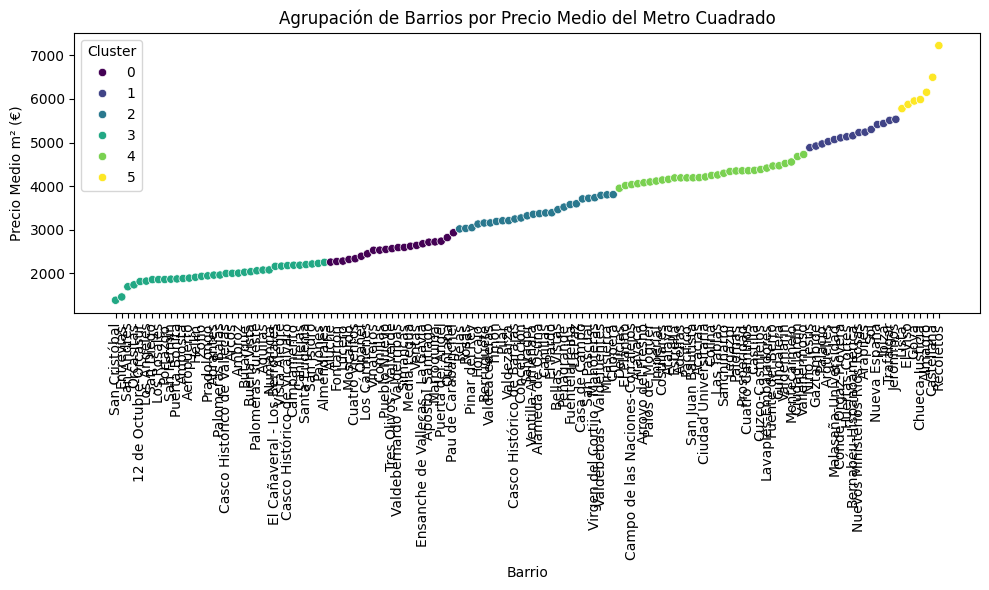

In [53]:
# Ordenar los barrios por precio medio y cluster
precio_medio_barrio.sort_values('Precio_medio_m2', inplace=True)

print(precio_medio_barrio)

# Visualización con Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=precio_medio_barrio, x='neighbourhood', y='Precio_medio_m2', hue='Cluster', palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('Precio Medio m² (€)')
plt.title('Agrupación de Barrios por Precio Medio del Metro Cuadrado')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


**Nos Aseguramos la Consistencia de los Nombres de Barrios entre los ficheros**

In [54]:
# Convertir a mayúsculas y eliminar espacios adicionales para asegurar coincidencias
precio_medio_barrio['neighbourhood'] = precio_medio_barrio['neighbourhood'].str.upper().str.strip()
gdf['LOCATIONNAME'] = gdf['LOCATIONNAME'].str.upper().str.strip()

# Opcional: Verificar barrios que no coinciden
barrios_df = set(precio_medio_barrio['neighbourhood'])
barrios_gdf = set(gdf['LOCATIONNAME'])
barrios_faltantes = barrios_df - barrios_gdf
if barrios_faltantes:
    print("Barrios en precio_medio_barrio que no están en gdf:", barrios_faltantes)

barrios_faltantes_gdf = barrios_gdf - barrios_df
if barrios_faltantes_gdf:
    print("Barrios en gdf que no están en precio_medio_barrio:", barrios_faltantes_gdf)


In [55]:
gdf.head()

,LOCATIONID,LOCATIONNAME,ZONELEVELID,WKT_geometry,mean_UNITPRICE
0,0-EU-ES-28-07-001-079-16-002,CONDE ORGAZ-PIOVERA,8,"MULTIPOLYGON (((-3.63014 40.44939, -3.62633 40...",4997.529056
1,0-EU-ES-28-07-001-079-16-004,PINAR DEL REY,8,"MULTIPOLYGON (((-3.655102 40.46681, -3.654251 ...",2890.201338
2,0-EU-ES-28-07-001-079-21-004,TIMÓN,8,"MULTIPOLYGON (((-3.581744 40.47973, -3.60157 4...",3131.335558
3,0-EU-ES-28-07-001-079-01-001,PALACIO,8,"MULTIPOLYGON (((-3.72044 40.42028, -3.72097 40...",4841.978005
4,0-EU-ES-28-07-001-079-01-003,HUERTAS-CORTES,8,"MULTIPOLYGON (((-3.696488 40.41881, -3.699685 ...",5353.127293


In [56]:
import geopandas as gpd
from shapely import wkt

# Asegúrate de que 'WKT_geometry' está en formato string
gdf['WKT_geometry'] = gdf['WKT_geometry'].astype(str)

# Convertir la columna WKT a objetos geométricos
gdf['geometry'] = gdf['WKT_geometry'].apply(wkt.loads)


# Asegurarse de que 'gdf' es un GeoDataFrame
# Si no lo es, convertirlo
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')  # Ajusta según corresponda

# Fusionar los DataFrames
gdf = gdf.merge(precio_medio_barrio[['neighbourhood', 'Cluster']], how='left',
                left_on='LOCATIONNAME', right_on='neighbourhood')

# Opcional: Verificar si hay valores NaN en 'Cluster' después de la fusión
barrios_sin_cluster = gdf[gdf['Cluster'].isna()]['LOCATIONNAME'].unique()
if len(barrios_sin_cluster) > 0:
    print("Barrios sin asignar a un cluster:", barrios_sin_cluster)

# Eliminar la columna 'Barrio' si ya no es necesaria
gdf.drop(columns=['neighbourhood'], inplace=True)


In [57]:
# Supongamos que tu GeoDataFrame se llama 'gdf' y tiene una columna 'Cluster'
# y una columna 'mean_UNITPRICE' que representa el precio medio por barrio.

# Calcular el precio medio por cluster
precio_medio_por_cluster = gdf.groupby('Cluster')['mean_UNITPRICE'].mean().reset_index()

print(precio_medio_por_cluster)


   Cluster  mean_UNITPRICE
0        0     2464.511952
1        1     5144.165401
2        2     3307.778962
3        3     1905.786641
4        4     4185.646563
5        5     6173.676259


In [58]:
# Ordenar los clusters por 'mean_UNITPRICE' de menor a mayor
precio_medio_por_cluster = precio_medio_por_cluster.sort_values('mean_UNITPRICE').reset_index(drop=True)

print(precio_medio_por_cluster)


   Cluster  mean_UNITPRICE
0        3     1905.786641
1        0     2464.511952
2        2     3307.778962
3        4     4185.646563
4        1     5144.165401
5        5     6173.676259


In [59]:
# Crear una lista de clusters ordenados por precio medio
clusters_ordenados = precio_medio_por_cluster['Cluster'].tolist()

# Crear un diccionario de mapeo: {cluster_original: cluster_nuevo}
mapeo_clusters = {cluster_original: nuevo_cluster for nuevo_cluster, cluster_original in enumerate(clusters_ordenados)}

print(mapeo_clusters)


{3: 0, 0: 1, 2: 2, 4: 3, 1: 4, 5: 5}


In [60]:
# Aplicar el mapeo para crear una nueva columna 'Cluster_Ordenado'
gdf['Cluster_Ordenado'] = gdf['Cluster'].map(mapeo_clusters)

# Opcional: Si deseas reemplazar la columna 'Cluster' original
# gdf_geo['Cluster'] = gdf_geo['Cluster'].map(mapeo_clusters)


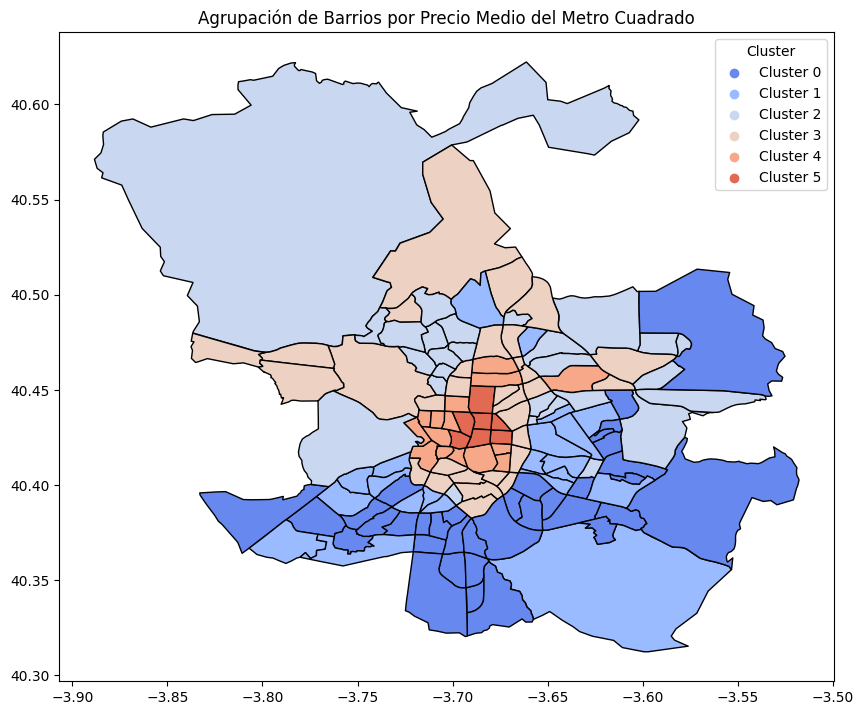

In [61]:
# Definir una paleta de colores
palette = sns.color_palette('coolwarm', k_optimo).as_hex()

# Asignar colores a cada cluster
gdf['color'] = gdf['Cluster_Ordenado'].apply(lambda x: palette[x])

# Plotear el mapa
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(color=gdf['color'], edgecolor='black', ax=ax)

# Añadir una leyenda
for cluster in range(k_optimo):
    ax.scatter([], [], c=palette[cluster], label=f'Cluster {cluster}')
ax.legend(title='Cluster')

plt.title('Agrupación de Barrios por Precio Medio del Metro Cuadrado')
plt.show()


In [62]:
gdf.head()

,LOCATIONID,LOCATIONNAME,ZONELEVELID,WKT_geometry,mean_UNITPRICE,geometry,Cluster,Cluster_Ordenado,color
0,0-EU-ES-28-07-001-079-16-002,CONDE ORGAZ-PIOVERA,8,"MULTIPOLYGON (((-3.63014 40.44939, -3.62633 40...",4997.529056,"MULTIPOLYGON (((-3.63014 40.44939, -3.62633 40...",1,4,#f7a889
1,0-EU-ES-28-07-001-079-16-004,PINAR DEL REY,8,"MULTIPOLYGON (((-3.655102 40.46681, -3.654251 ...",2890.201338,"MULTIPOLYGON (((-3.6551 40.46681, -3.65425 40....",2,2,#c9d7f0
2,0-EU-ES-28-07-001-079-21-004,TIMÓN,8,"MULTIPOLYGON (((-3.581744 40.47973, -3.60157 4...",3131.335558,"MULTIPOLYGON (((-3.58174 40.47973, -3.60157 40...",2,2,#c9d7f0
3,0-EU-ES-28-07-001-079-01-001,PALACIO,8,"MULTIPOLYGON (((-3.72044 40.42028, -3.72097 40...",4841.978005,"MULTIPOLYGON (((-3.72044 40.42028, -3.72097 40...",1,4,#f7a889
4,0-EU-ES-28-07-001-079-01-003,HUERTAS-CORTES,8,"MULTIPOLYGON (((-3.696488 40.41881, -3.699685 ...",5353.127293,"MULTIPOLYGON (((-3.69649 40.41881, -3.69968 40...",1,4,#f7a889


**Seleccionamos las Columnas Relevantes de gdf**


In [63]:
# Seleccionar columnas necesarias
clusters_info = gdf[['LOCATIONNAME', 'Cluster_Ordenado']]


In [64]:
clusters_info

,LOCATIONNAME,Cluster_Ordenado
0,CONDE ORGAZ-PIOVERA,4
1,PINAR DEL REY,2
2,TIMÓN,2
3,PALACIO,4
4,HUERTAS-CORTES,4
...,...,...
130,FUENTELARREINA,2
131,PEÑAGRANDE,2
132,LOS CÁRMENES,1
133,CASA DE CAMPO,2


In [65]:
# Convertir a mayúsculas y eliminar espacios al inicio y al final
df_Madrid['neighbourhood'] = df_Madrid['neighbourhood'].str.upper().str.strip()
gdf['LOCATIONNAME'] = gdf['LOCATIONNAME'].str.upper().str.strip()


**Realizamos la Fusión (Merge) de df_Madrid con gdf**

In [66]:
# Fusionar df_Madrid con clusters_info
df_Madrid = df_Madrid.merge(clusters_info, how='left', left_on='neighbourhood', right_on='LOCATIONNAME')

# Opcional: Eliminar la columna 'LOCATIONNAME' si ya no es necesaria
df_Madrid.drop(columns=['LOCATIONNAME'], inplace=True)


In [67]:
df_Madrid.head()

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m,Precio_medio_m2,diferencia_precio_m2,Cluster_Ordenado
0,A2624736749193113090,4,166000,1844.444444,HOME,SALE,90,2,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1.0,1986,10,32,5.0,0,0,1,7.953755,0.402011,6.504196,-3.611866,40.431013,Madrid,HOME,SALE,HELLÍN,2,1898.550087,-0.028498,0
1,A1897858214850462442,4,125000,2016.129032,HOME,SALE,62,3,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,1.0,1960,5,11,7.0,0,0,1,7.613618,0.153489,6.203659,-3.615529,40.429363,Madrid,HOME,SALE,HELLÍN,1,1898.550087,0.061931,0
2,A4711159002766766142,4,96000,1920.000000,HOME,SALE,50,2,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.0,1960,5,13,7.0,0,1,0,7.231945,0.360233,5.879094,-3.619613,40.427260,Madrid,HOME,SALE,AMPOSTA,1,1853.618895,0.035812,0
3,A4518523185663624687,4,301000,2370.078740,HOME,SALE,127,3,2,1,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.0,1999,3,25,4.0,0,0,1,7.568203,0.065119,6.182529,-3.615863,40.428488,Madrid,HOME,SALE,AMPOSTA,1,1853.618895,0.278622,0
4,A8373956059305031989,4,90000,1666.666667,HOME,SALE,54,2,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.0,1960,4,10,7.0,0,0,1,6.973876,0.485759,5.705246,-3.622170,40.424562,Madrid,HOME,SALE,AMPOSTA,1,1853.618895,-0.100858,0


**Verificamos la Asignación de Clusters**

In [68]:
# Verificar si hay pisos sin asignar a un cluster
pisos_sin_cluster = df_Madrid[df_Madrid['Cluster_Ordenado'].isna()]
num_sin_cluster = pisos_sin_cluster.shape[0]

if num_sin_cluster > 0:
    print(f"Hay {num_sin_cluster} pisos sin asignar a un cluster:")
    print(pisos_sin_cluster[['neighbourhood']].drop_duplicates())
else:
    print("Todos los pisos han sido asignados a un cluster.")


Todos los pisos han sido asignados a un cluster.


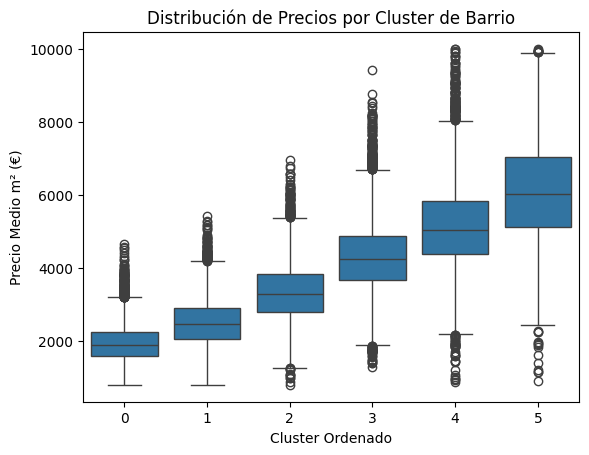

In [69]:
sns.boxplot(data=df_Madrid, x='Cluster_Ordenado', y='UNITPRICE')

plt.title('Distribución de Precios por Cluster de Barrio')
plt.xlabel('Cluster Ordenado')
plt.ylabel('Precio Medio m² (€)')
plt.show()


## ML Models

In [70]:
df_Madrid.columns

Index(['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'ADTYPOLOGYID',
       'ADOPERATIONID', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
       'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'AMENITYID',
       'HASPARKINGSPACE', 'HASNORTHORIENTATION', 'HASSOUTHORIENTATION',
       'HASEASTORIENTATION', 'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE',
       'HASSWIMMINGPOOL', 'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO',
       'ISINTOPFLOOR', 'FLOORCLEAN', 'FLATLOCATIONID', 'CADCONSTRUCTIONYEAR',
       'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT', 'CADASTRALQUALITYID',
       'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_STREET',
       'LONGITUDE', 'LATITUDE', 'CITYNAME', 'ADTYPOLOGY', 'ADOPERATION',
       'neighbourhood', 'metros_within_500m', 'Precio_medio_m2',
       'diferencia_precio_m2', 'Cluster_Ordenado'],
      dtype='object')

In [71]:
# prompt: crea una nueva columna llamada BUILTTYPE que valga 1 si BUITTYPEID_1 vale 1, 2 si BUITTYPEID_2 vale 1 y 3 si BUITTYPEID_3 vale 1

# Create the 'BUILTTYPE' column based on the conditions
df_Madrid['BUILTTYPE'] = 0  # Initialize the column with 0
df_Madrid.loc[df_Madrid['BUILTTYPEID_1'] == 1, 'BUILTTYPE'] = 1
df_Madrid.loc[df_Madrid['BUILTTYPEID_2'] == 1, 'BUILTTYPE'] = 2
df_Madrid.loc[df_Madrid['BUILTTYPEID_3'] == 1, 'BUILTTYPE'] = 3

In [74]:

madrid = df_Madrid.drop(columns=['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'ADTYPOLOGYID',
       'ADOPERATIONID','AMENITYID','HASNORTHORIENTATION', 'HASSOUTHORIENTATION',
       'HASEASTORIENTATION', 'HASWESTORIENTATION','FLATLOCATIONID',
       'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT', 'CADASTRALQUALITYID','DISTANCE_TO_METRO',
       'LONGITUDE', 'LATITUDE', 'CITYNAME', 'ADTYPOLOGY', 'ADOPERATION',
       'neighbourhood', 'metros_within_500m','BUILTTYPEID_1','BUILTTYPEID_2','BUILTTYPEID_3','DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_STREET'])

In [75]:
madrid.columns

Index(['CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE', 'HASLIFT',
       'HASAIRCONDITIONING', 'HASPARKINGSPACE', 'HASBOXROOM', 'HASWARDROBE',
       'HASSWIMMINGPOOL', 'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO',
       'ISINTOPFLOOR', 'FLOORCLEAN', 'CADCONSTRUCTIONYEAR', 'Precio_medio_m2',
       'diferencia_precio_m2', 'Cluster_Ordenado', 'BUILTTYPE'],
      dtype='object')

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
import statsmodels.api as sm

X = madrid.drop(['diferencia_precio_m2'], axis=1)
y = madrid['diferencia_precio_m2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [77]:
y_test.shape

(6140,)

In [78]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model_sm = sm.OLS(y_train, X_train_sm).fit()

y_pred = model_sm.predict(X_test_sm)

mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

print(model_sm.summary())

MAE: 0.15859114024942447
MDAE: 0.1253701695162865
RMSE: 0.20888925766237756
MAPE: 294.38370889523515%
                             OLS Regression Results                             
Dep. Variable:     diferencia_precio_m2   R-squared:                       0.217
Model:                              OLS   Adj. R-squared:                  0.216
Method:                   Least Squares   F-statistic:                     340.2
Date:                  Fri, 22 Nov 2024   Prob (F-statistic):               0.00
Time:                          20:11:53   Log-Likelihood:                 3622.5
No. Observations:                 24558   AIC:                            -7203.
Df Residuals:                     24537   BIC:                            -7033.
Df Model:                            20                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]


In [79]:
# prompt: define una función con X_test y y_pred como input, y MAE, MSE, Medae y mape como output

import numpy as np
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

def calculate_metrics(X_test, y_pred, y_test):
    """
    Calculates MAE, MSE, MedAE, and MAPE.

    Args:
        X_test: Test features (not used in the calculations, but included for consistency with the original code).
        y_pred: Predicted values.
        y_test: True values.

    Returns:
        A dictionary containing MAE, MSE, MedAE, and MAPE.
    """
    indices_test = X_test.index
    price_test = df_Madrid.loc[indices_test, 'UNITPRICE'] * df_Madrid.loc[indices_test, 'CONSTRUCTEDAREA']

    unitprice_pred = (1 + y_pred)  * X_test['Precio_medio_m2']
    price_pred = unitprice_pred * X_test['CONSTRUCTEDAREA']

    mae = mean_absolute_error(price_test, price_pred)
    mse = mean_squared_error(price_test, price_pred)
    medae = median_absolute_error(price_test, price_pred)
    mape = np.mean(np.abs((price_test- price_pred) / price_test)) * 100

    return {'mae': mae, 'mse': mse, 'medae': medae, 'mape': mape}

In [85]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 3. Entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# 4. Realizar predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)


# imprimir error medio en precios, en %
error_medio_precios = calculate_metrics(X_test, y_pred, y_test)['mape']
print(f'Error medio en precios con regresión lineal: {error_medio_precios:.2f}%')


Error medio en precios con regresión lineal: 17.29%


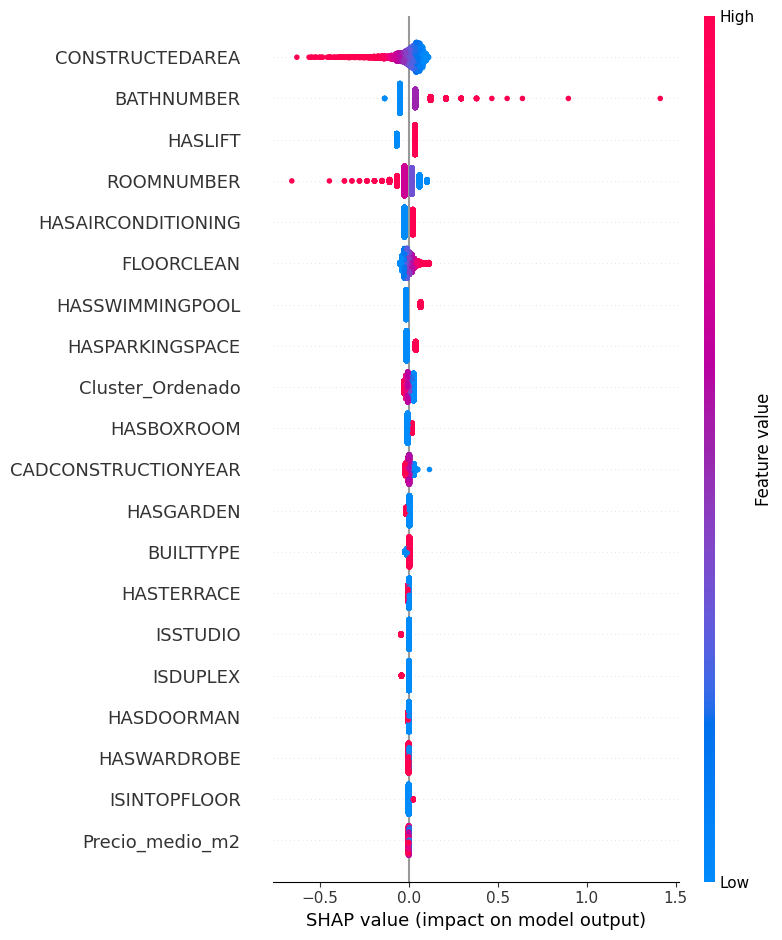

In [84]:
import shap

# Crear un objeto explainer
explainer = shap.Explainer(modelo, X_train)
shap_values = explainer(X_test)

# Visualizar los valores SHAP
shap.summary_plot(shap_values, X_test)


*Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}*

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
                Feature  Importance
0       CONSTRUCTEDAREA    0.220573
17      Precio_medio_m2    0.172805
16  CADCONSTRUCTIONYEAR    0.149899
15           FLOORCLEAN    0.100700
1            ROOMNUMBER    0.059293
4               HASLIFT    0.049480
19            BUILTTYPE    0.039648
9       HASSWIMMINGPOOL    0.030332
2            BATHNUMBER    0.027319
5    HASAIRCONDITIONING    0.021153
3            HASTERRACE    0.019132
8           HASWARDROBE    0.019014
18     Cluster_Ordenado    0.018862
6       HASPARKINGSPACE    0.017416
7            HASBOXROOM    0.015635
10           HASDOORMAN    0.013827
11            HASGARDEN    0.010171
14         ISINTOPFLOOR    0.006739
12             ISDUPLEX    0.005069
13             ISSTUDIO    0.002934


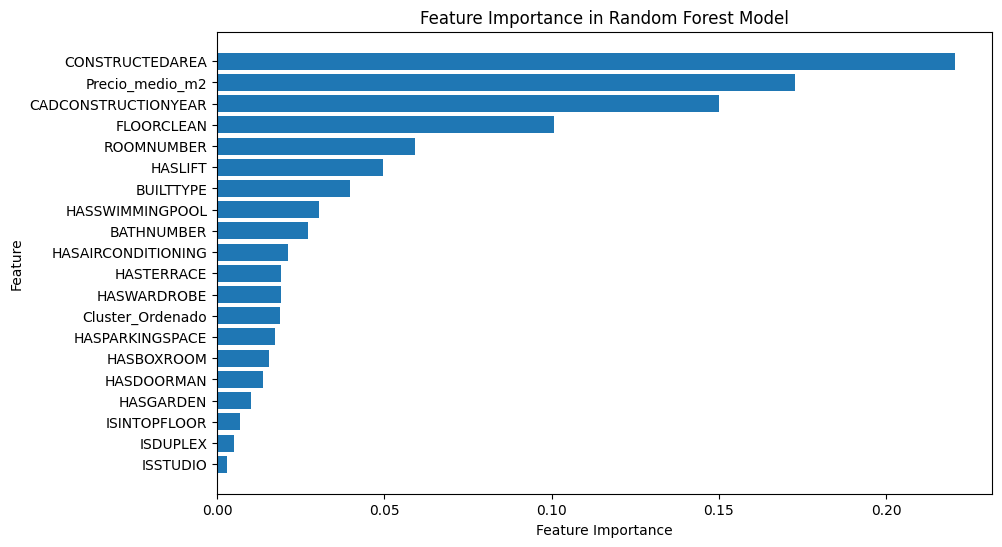

In [86]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
#import matplotlib.pyplot as plt


rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [300], #[100, 200, 300]
    'max_depth': [None], #[10, 20, None]
    'min_samples_split': [2], #[2, 5, 10]
    'min_samples_leaf': [1], #[1, 2, 4]
    'bootstrap': [True] #[True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)


print(f'Best parameters found: {grid_search.best_params_}')

feature_importances = best_rf.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [87]:
# imprimir error medio en precios, en %
error_medio_precios = calculate_metrics(X_test, y_pred, y_test)['mape']
print(f'Error medio en precios con random forest: {error_medio_precios:.2f}%')

Error medio en precios con random forest: 13.35%


*Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 1.0}*


In [88]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [300], #[100, 200, 300],
    'max_depth': [10],#[3, 5, 7, 10],
    'learning_rate': [0.05], #[0.01, 0.05, 0.1, 0.2],
    'subsample': [1], #[0.6, 0.8, 1.0],
    'colsample_bytree':[0.6], #[0.6, 0.8, 1.0],
    'reg_alpha': [0.1], #[0, 0.1, 0.5, 1],
    'reg_lambda': [0] #[0, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test)

print(f'Best parameters found: {grid_search.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 1}


In [89]:
# imprimir error medio en precios, en %
error_medio_precios = calculate_metrics(X_test, y_pred, y_test)['mape']
print(f'Error medio en precios con xgboost: {error_medio_precios:.2f}%')

Error medio en precios con xgboost: 13.08%


In [91]:
# Solo si deseas verificar (no recomendado para evaluar rendimiento)
y_pred_all = best_xgb.predict(X)
error_medio_precios = calculate_metrics(X, y_pred_all, y)['mape']
print(f'Error medio en precios totales con xgboost: {error_medio_precios:.2f}%')

Error medio en precios totales con xgboost: 8.56%
